# Tensorboard
- TensorFlow에서 제공하는 시각화 툴
- 학습하는 중간의 그래프나 여러가지 정보를 Web UI로 조회 가능
- 학습 log를 시각화 하는 것이라고 보면 됨

https://www.tensorflow.org/tensorboard?hl=ko

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(7777)
tf.random.set_seed(7777)

In [2]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

cifar10_loader = Cifar10DataLoader()
train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = cifar10_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [4]:
def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(16, kernel_size=3, strides=2,
                 padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)
    
    net1 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net2)
    
    net1_1 = Conv2D(32, kernel_size=1, padding='same')(net)
    net = Add()([net1_1, net3])
    
    net1 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3])
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation="softmax")(net)

    model = tf.keras.Model(inputs=inputs, outputs=net, name='resnet')
    
    return model

model = build_resnet((32, 32, 3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 16)   448         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 16)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 32)     544         ['max_pooling2d[0][0]']          
                                                                                             

## (1) fit 함수로 학습 => callback 함수 사용! 
- TensorBoard 가 시각화할 때 사용할 log를 callback 함수로 작성
- log_dir 을 계획적으로 정리해서 log들을 잘 저장하는 것이 중요하다

#### callback 함수 설정
- 파일명을 사용하는 logs/모델명/만든시간 으로 설정

In [6]:
import datetime

cur_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

lod_dir = "logs/fit/" + cur_time
lod_dir

'logs/fit/20221201-214007'

In [8]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=lod_dir)

#### lr, loss, opt 설정

In [5]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

#### fit

In [9]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=5,
          validation_data=(test_x, test_y), 
          callbacks=[tb_callback])

Epoch 1/5
1563/1563 [==============================] - 28s 17ms/step - loss: 2.3439 - accuracy: 0.1005 - val_loss: 2.3302 - val_accuracy: 0.1000
Epoch 2/5
1563/1563 [==============================] - 26s 16ms/step - loss: 2.3357 - accuracy: 0.1029 - val_loss: 2.3209 - val_accuracy: 0.1000
Epoch 3/5
1563/1563 [==============================] - 26s 16ms/step - loss: 2.3409 - accuracy: 0.0978 - val_loss: 2.3737 - val_accuracy: 0.1000
Epoch 4/5
1563/1563 [==============================] - 32s 21ms/step - loss: 2.3401 - accuracy: 0.0987 - val_loss: 2.3292 - val_accuracy: 0.1000
Epoch 5/5
1563/1563 [==============================] - 30s 19ms/step - loss: 2.3431 - accuracy: 0.0994 - val_loss: 2.3364 - val_accuracy: 0.1000


#### TensorBoard  실행
- 원래는 터미널에서 실행
- 외부 서버에서 주피터에 접속한 경우 맨 뒤에  `--bind_all` 를 붙여준다.

In [14]:
!tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


## (2) 내가 만든 함수로 학습 => tf.summary 사용! 

#### 함수 제작

In [15]:
loss_fn = tf.keras.losses.categorical_crossentropy

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(x, y) :
    with tf.GradientTape() as tape:
        pred = model(x)
        loss = loss_fn(y, pred)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y, pred)

@tf.function
def test_step(x, y) :
    
    pred = model(x)
    loss = loss_fn(y, pred)
    
    test_loss(loss)
    test_accuracy(y, pred)

#### 로그 저장 경로 설정
- callback 함수는 train, test 파일을 자동으로 따로 저장해주지만
- 이번 경우에는 내가 수동으로 따로 저장해야 한다.

In [16]:
train_log_dir = "logs/gradtape/train/" + cur_time
test_log_dir = "logs/gradtape/test/" + cur_time

#### tf.summary 사용
- 인자로 파일 저장위치를 받는다.

In [20]:
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

#### 학습
- 매 epoch 마다 log를 기록

In [21]:
batch_size = 64

num_of_batch_train = train_x.shape[0] // batch_size
num_of_batch_test = test_x.shape[0] // batch_size

for epoch in range(5):
    
    for i in range(num_of_batch_train):
        idx = i * batch_size
        x, y = train_x[idx:idx+batch_size], train_y[idx:idx+batch_size]
        train_step(x, y)
        print("\r Train : {} / {}".format(i, num_of_batch_train), end='\r')

        
    for i in range(num_of_batch_test):
        idx = i * batch_size
        x, y = test_x[idx:idx+batch_size], test_y[idx:idx+batch_size]
        test_step(x, y)
        print("\r Test : {} / {}".format(i, num_of_batch_test), end='\r')
        
    # log 기록(loss, acc는 scalar라서 tf.summary.scalar 안에 들어있다)    
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('acc', train_accuracy.result(), step=epoch)
        
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('acc', test_accuracy.result(), step=epoch)
        
    fmt = 'epoch {} loss: {}, accuracy: {}, test_loss: {}, test_acc: {}'
    print(fmt.format(epoch+1, 
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()
                    ))
    
    # 매 epoch 마다 loss, acc 값 reset
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

epoch 1 loss: 2.355724573135376, accuracy: 0.09937179833650589, test_loss: 2.3273210525512695, test_acc: 0.09995993226766586
epoch 2 loss: 2.320366621017456, accuracy: 0.0985715463757515, test_loss: 2.307554006576538, test_acc: 0.09985977411270142
epoch 3 loss: 2.3251609802246094, accuracy: 0.09889164566993713, test_loss: 2.3238322734832764, test_acc: 0.09985977411270142
epoch 4 loss: 2.3269894123077393, accuracy: 0.0997319146990776, test_loss: 2.3113343715667725, test_acc: 0.09985977411270142
epoch 5 loss: 2.326922655105591, accuracy: 0.0988716408610344, test_loss: 2.318948268890381, test_acc: 0.10016025602817535


In [22]:
!tensorboard --logdir logs/gradient_tape

^C


## (3) Tensorboard에 이미지 데이터 기록

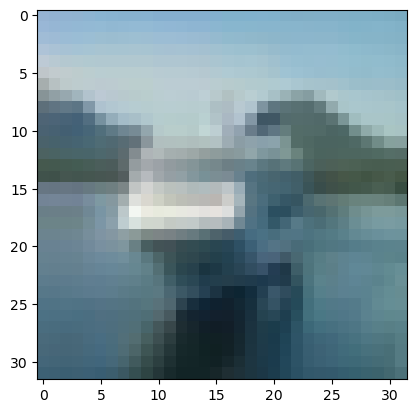

In [23]:
img = train_x[777]

plt.imshow(img)
plt.show()

In [24]:
logdir = "logs/train_data/" + cur_time
logdir

'logs/train_data/20221201-214007'

In [25]:
file_writer = tf.summary.create_file_writer(logdir)

for i in np.random.randint(10000, size=10):    
    img = train_x[i:i+1]  # 사진 파일의 차우너을 줄이지 않기 위한 slicing 
    
    with file_writer.as_default():
        tf.summary.image("Training Sample data : {}".format(i), img, step=0)

In [26]:
!tensorboard --logdir logs/train_data

^C


## (4) LambdaCallback을 사용하여 Tensorboard에 Confusion Matrix 기록

In [27]:
import io
from sklearn.metrics import confusion_matrix

def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

def plot_confusion_matrix(cm, class_names):

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

logdir = "logs/fit/cm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm = tf.summary.create_file_writer(logdir)

test_images = test_x[:100]
test_labels = np.argmax(test_y[:100], axis=1)

def log_confusion_matrix(epoch, logs):
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    classes = np.arange(10)
    cm = confusion_matrix(test_labels, test_pred, labels=classes)
    
    figure = plot_confusion_matrix(cm, class_names=classes)
    cm_image = plot_to_image(figure)

    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [28]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [30]:
model.fit(x=train_x, 
          y=train_y,
          epochs=5,
          batch_size=32,
          validation_data=(test_x, test_y),
          callbacks=[tb_callback, cm_callback])

Epoch 1/5
1563/1563 [==============================] - 39s 25ms/step - loss: 2.3066 - accuracy: 0.1001 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 2/5
1563/1563 [==============================] - 43s 27ms/step - loss: 2.3054 - accuracy: 0.1027 - val_loss: 2.3066 - val_accuracy: 0.1000
Epoch 3/5
1563/1563 [==============================] - 43s 27ms/step - loss: 2.3044 - accuracy: 0.0976 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 4/5
1563/1563 [==============================] - 31s 20ms/step - loss: 2.3052 - accuracy: 0.0999 - val_loss: 2.3071 - val_accuracy: 0.1000
Epoch 5/5
1563/1563 [==============================] - 31s 20ms/step - loss: 2.3192 - accuracy: 0.0989 - val_loss: 2.3613 - val_accuracy: 0.1000


In [ ]:
!tensorboard --logdir logs/fit